# Colab E(i): TensorFlow From Scratch — Low-Level API Only

**No Keras, No High-Level API — Pure `tf.Variable`, `tf.GradientTape`, `tf.einsum`**

---

### Key Requirements
- Raw `tf.Variable` for weights (no `tf.keras.layers`)
- `tf.GradientTape` for automatic differentiation
- `tf.einsum` for matrix multiplications
- Manual training loop
- Same 3-variable non-linear regression

## Cell 1: Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

tf.random.set_seed(42)
np.random.seed(42)
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow version: 2.19.0
GPU available: False


## Cell 2: Generate Synthetic Data

$$y = \sin(x_1) \cdot x_2^2 + \cos(x_3) \cdot x_1 + 0.5 \cdot x_3 \cdot x_2$$

In [2]:
num_samples = 2000
x1 = np.random.uniform(-2, 2, num_samples)
x2 = np.random.uniform(-2, 2, num_samples)
x3 = np.random.uniform(-2, 2, num_samples)
y_true = np.sin(x1) * x2**2 + np.cos(x3) * x1 + 0.5 * x3 * x2

X_np = np.column_stack([x1, x2, x3]).astype(np.float32)
Y_np = y_true.reshape(-1, 1).astype(np.float32)

X_mean, X_std = X_np.mean(0), X_np.std(0)
Y_mean, Y_std = Y_np.mean(), Y_np.std()
X_norm = ((X_np - X_mean) / X_std).astype(np.float32)
Y_norm = ((Y_np - Y_mean) / Y_std).astype(np.float32)

# Create tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((X_norm, Y_norm))
dataset = dataset.shuffle(2000).batch(64)

print(f"Samples: {num_samples} | Features: 3 | Batches: {len(list(dataset))}")

Samples: 2000 | Features: 3 | Batches: 32


## Cell 3: 4D Visualization

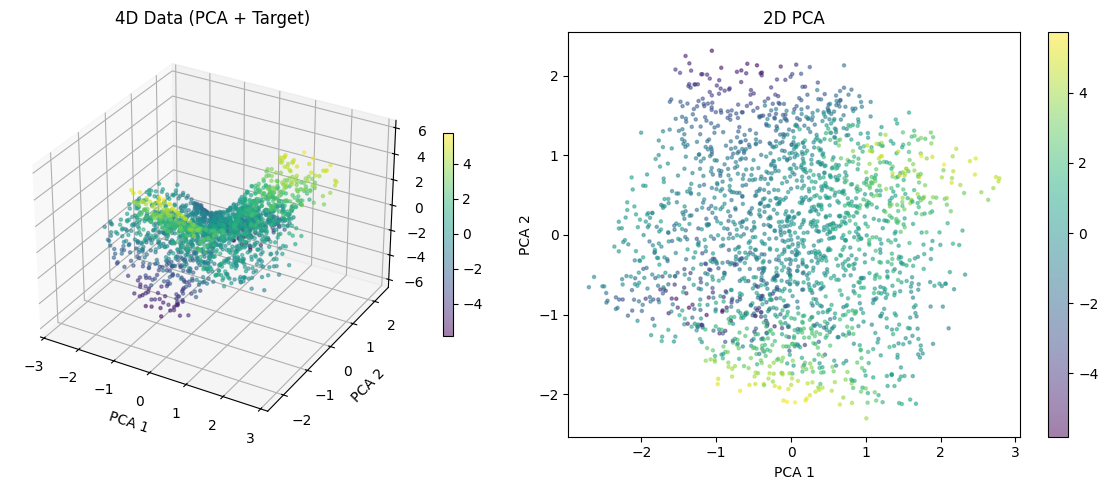

In [3]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121, projection='3d')
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], Y_np.flatten(), c=Y_np.flatten(), cmap='viridis', s=5, alpha=0.5)
ax.set_xlabel('PCA 1'); ax.set_ylabel('PCA 2'); ax.set_zlabel('y')
ax.set_title('4D Data (PCA + Target)')
plt.colorbar(sc, ax=ax, shrink=0.5)

ax2 = fig.add_subplot(122)
sc2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=Y_np.flatten(), cmap='viridis', s=5, alpha=0.5)
ax2.set_xlabel('PCA 1'); ax2.set_ylabel('PCA 2'); ax2.set_title('2D PCA')
plt.colorbar(sc2, ax=ax2)
plt.tight_layout(); plt.show()

## Cell 4: Initialize Raw tf.Variable Weights

**Architecture:** 3 → 64 (ReLU) → 32 (ReLU) → 16 (ReLU) → 1 (Linear)

No `tf.keras.layers.Dense` — only raw `tf.Variable`.

In [4]:
# He initialization
def he_init(shape):
    return tf.random.normal(shape) * tf.sqrt(2.0 / shape[0])

# Raw tf.Variable weights — NO keras layers
W1 = tf.Variable(he_init([3, 64]), name='W1')
b1 = tf.Variable(tf.zeros([64]), name='b1')

W2 = tf.Variable(he_init([64, 32]), name='W2')
b2 = tf.Variable(tf.zeros([32]), name='b2')

W3 = tf.Variable(he_init([32, 16]), name='W3')
b3 = tf.Variable(tf.zeros([16]), name='b3')

W4 = tf.Variable(he_init([16, 1]), name='W4')
b4 = tf.Variable(tf.zeros([1]), name='b4')

all_weights = [W1, b1, W2, b2, W3, b3, W4, b4]
total_params = sum(w.numpy().size for w in all_weights)

print("Low-level TF Variables (no Keras):")
for w in all_weights:
    print(f"  {w.name}: {w.shape}")
print(f"Total params: {total_params}")

Low-level TF Variables (no Keras):
  W1:0: (3, 64)
  b1:0: (64,)
  W2:0: (64, 32)
  b2:0: (32,)
  W3:0: (32, 16)
  b3:0: (16,)
  W4:0: (16, 1)
  b4:0: (1,)
Total params: 2881


## Cell 5: Forward Pass with tf.einsum

In [5]:
def forward(X):
    """Forward pass using tf.einsum for matrix multiply — no keras."""
    # Layer 1
    z1 = tf.einsum('ij,jk->ik', X, W1) + b1
    a1 = tf.nn.relu(z1)

    # Layer 2
    z2 = tf.einsum('ij,jk->ik', a1, W2) + b2
    a2 = tf.nn.relu(z2)

    # Layer 3
    z3 = tf.einsum('ij,jk->ik', a2, W3) + b3
    a3 = tf.nn.relu(z3)

    # Output (linear)
    z4 = tf.einsum('ij,jk->ik', a3, W4) + b4
    return z4

# Test
test_out = forward(tf.constant(X_norm[:5]))
print(f"Output shape: {test_out.shape}")
print(f"Values: {test_out.numpy().flatten()}")

Output shape: (5, 1)
Values: [-0.5694955  -0.07729179  0.5212382   1.312548   -0.4654383 ]


## Cell 6: Loss & Training Step with GradientTape

In [6]:
learning_rate = 0.001

def compute_loss(y_pred, y_true):
    """Mean Squared Error."""
    return tf.reduce_mean(tf.square(y_pred - y_true))

def train_step(x_batch, y_batch):
    """One training step: forward, loss, backward, update."""
    with tf.GradientTape() as tape:
        predictions = forward(x_batch)
        loss = compute_loss(predictions, y_batch)

    # Compute gradients
    gradients = tape.gradient(loss, all_weights)

    # Manual SGD update (no optimizer object)
    for w, g in zip(all_weights, gradients):
        w.assign_sub(learning_rate * g)

    return loss

print("Training step function defined (GradientTape + manual SGD).")

Training step function defined (GradientTape + manual SGD).


## Cell 7: Training Loop

In [7]:
epochs = 200
loss_history = []

for epoch in range(epochs):
    epoch_loss = 0.0
    n_batches = 0

    for x_batch, y_batch in dataset:
        loss = train_step(x_batch, y_batch)
        epoch_loss += loss.numpy()
        n_batches += 1

    avg_loss = epoch_loss / n_batches
    loss_history.append(avg_loss)

    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:>3}/{epochs} | Loss: {avg_loss:.6f}")

print(f"\nFinal Loss: {loss_history[-1]:.6f}")

Epoch   1/200 | Loss: 0.815765
Epoch  20/200 | Loss: 0.111163
Epoch  40/200 | Loss: 0.065707
Epoch  60/200 | Loss: 0.054629
Epoch  80/200 | Loss: 0.046264
Epoch 100/200 | Loss: 0.042982
Epoch 120/200 | Loss: 0.039667
Epoch 140/200 | Loss: 0.037788
Epoch 160/200 | Loss: 0.035242
Epoch 180/200 | Loss: 0.035069
Epoch 200/200 | Loss: 0.033007

Final Loss: 0.033007


## Cell 8: Plot Loss Curve

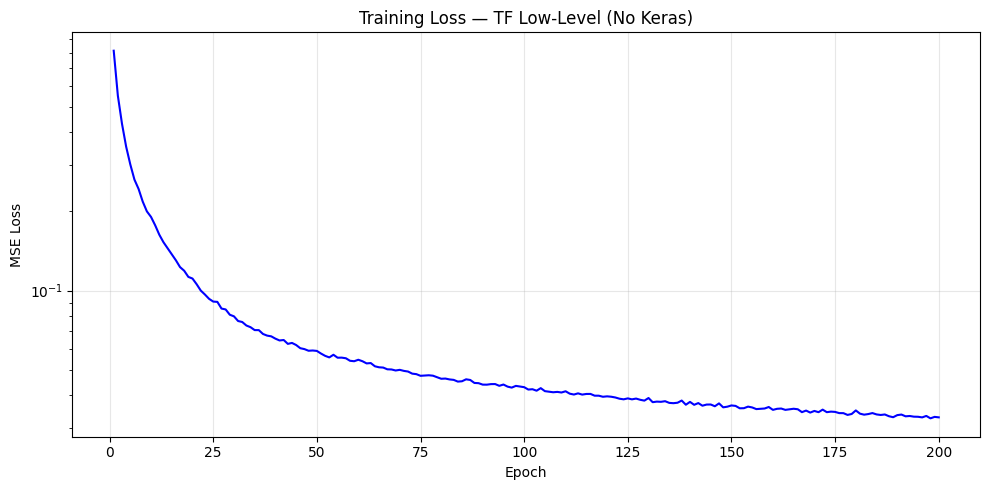

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), loss_history, 'b-', linewidth=1.5)
plt.xlabel('Epoch'); plt.ylabel('MSE Loss')
plt.title('Training Loss — TF Low-Level (No Keras)')
plt.grid(True, alpha=0.3); plt.yscale('log')
plt.tight_layout(); plt.show()

## Cell 9: Final Predictions & Results

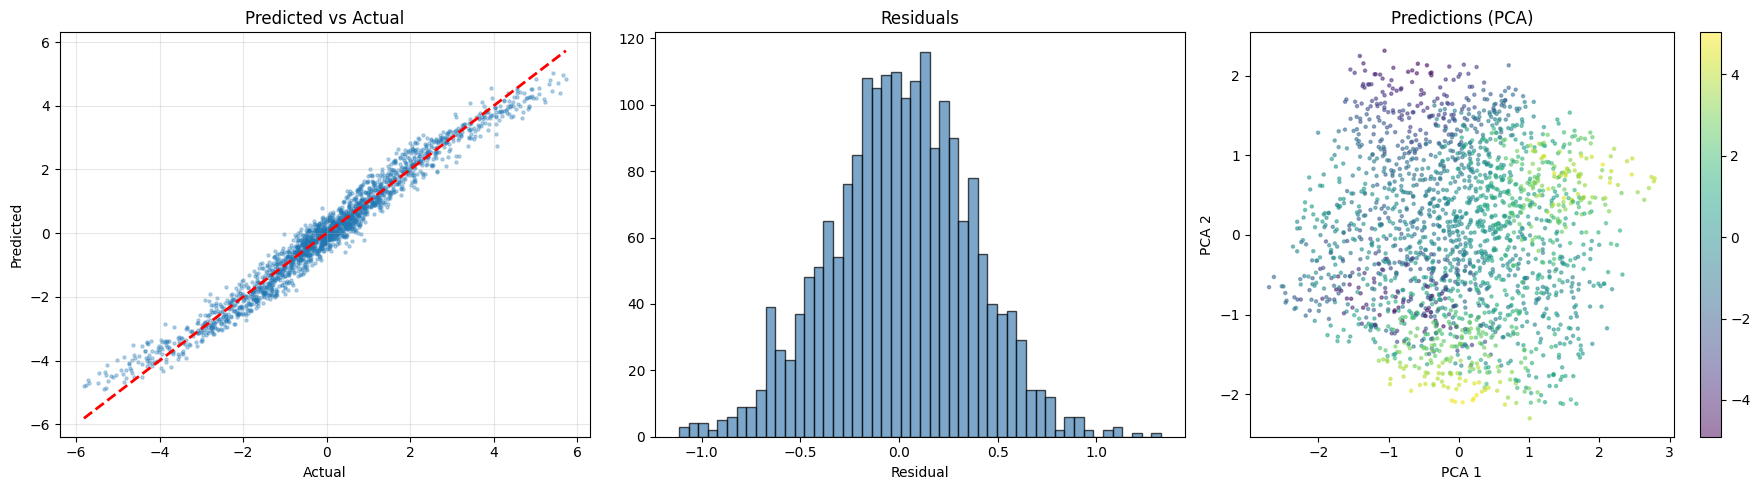

R²: 0.9672 | MAE: 0.2844


In [9]:
Y_pred_all = forward(tf.constant(X_norm)).numpy()
Y_pred_denorm = Y_pred_all * Y_std + Y_mean
residuals = Y_np.flatten() - Y_pred_denorm.flatten()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(Y_np.flatten(), Y_pred_denorm.flatten(), alpha=0.3, s=5)
axes[0].plot([Y_np.min(), Y_np.max()], [Y_np.min(), Y_np.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual'); axes[0].set_ylabel('Predicted')
axes[0].set_title('Predicted vs Actual'); axes[0].grid(True, alpha=0.3)

axes[1].hist(residuals, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Residual'); axes[1].set_title('Residuals')

sc = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=Y_pred_denorm.flatten(), cmap='viridis', s=5, alpha=0.5)
axes[2].set_xlabel('PCA 1'); axes[2].set_ylabel('PCA 2')
axes[2].set_title('Predictions (PCA)')
plt.colorbar(sc, ax=axes[2])
plt.tight_layout(); plt.show()

r2 = 1 - np.sum(residuals**2) / np.sum((Y_np.flatten() - Y_np.mean())**2)
print(f"R²: {r2:.4f} | MAE: {np.mean(np.abs(residuals)):.4f}")

## Cell 10: Summary

In [10]:
print("="*60)
print("Colab E(i): TF Low-Level From Scratch — Complete!")
print("="*60)
print("Uses: tf.Variable, tf.GradientTape, tf.einsum, tf.nn.relu")
print("NOT used: tf.keras.layers, tf.keras.Model, optimizers")
print(f"R²: {r2:.4f}")
print("="*60)

Colab E(i): TF Low-Level From Scratch — Complete!
Uses: tf.Variable, tf.GradientTape, tf.einsum, tf.nn.relu
NOT used: tf.keras.layers, tf.keras.Model, optimizers
R²: 0.9672
